Este trabajo es mi reporte para el proyecto del segundo parcial de la materia de Inteligencia Artificial. En este trabajo voy a entrenar distintos modelos para poder participar en el concurso de "Spaceship Titanic" de Kaggle. 

Se empezará importando la base de datos e imprimiendo el tamaño de cada conjunto de entrenamiento y prueba y transformando datos para que se puedan utilizar.

La columna de cabina se transformó a dos columnas "Deck" y "P/S", para poder utilizar el string que viene originalmente. Se va a ignorar el número de cuarto en este caso porque no se considera que pueda afectar mucho el resultado. 

También se transformó el passenger ID para incluirlo, como un consejo que se encontró en el foro de discusión del concurso (aunque no se guardó el enlace para referenciarlo directamente, se reconoce que de ahí salió la idea) porque relaciona a algunos de los pasajeros como familiares. 


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold


test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")


out1 = np.where(train["Cabin"].isnull())
#codigo con la ayuda de la respuest de https://stackoverflow.com/questions/35552874/get-first-letter-of-a-string-from-column
train["Deck"] = train["Cabin"].str[0]
train["P/S"] = train["Cabin"].str[-1]
train.PassengerId = train.PassengerId.str[-2:] 
test["Deck"] = test["Cabin"].str[0]
test["P/S"] = test["Cabin"].str[-1]
TestPId = test.PassengerId
test.PassengerId = test.PassengerId.str[-2:]

TrainPid = train.PassengerId
drop = ["Name","Cabin"]

test = test.drop(drop,axis=1)
train = train.drop(drop,axis=1)
print(test.head())
print(train.head())

print(train.dtypes)

print("Test shape",test.shape)
print("Train shape",train.shape)

for column in train.columns:
    #Linea generada con la ayuda de chat gpt
    print(train[column].value_counts())


  PassengerId HomePlanet CryoSleep  Destination   Age    VIP  RoomService  \
0          01      Earth      True  TRAPPIST-1e  27.0  False          0.0   
1          01      Earth     False  TRAPPIST-1e  19.0  False          0.0   
2          01     Europa      True  55 Cancri e  31.0  False          0.0   
3          01     Europa     False  TRAPPIST-1e  38.0  False          0.0   
4          01      Earth     False  TRAPPIST-1e  20.0  False         10.0   

   FoodCourt  ShoppingMall     Spa  VRDeck Deck P/S  
0        0.0           0.0     0.0     0.0    G   S  
1        9.0           0.0  2823.0     0.0    F   S  
2        0.0           0.0     0.0     0.0    C   S  
3     6652.0           0.0   181.0   585.0    C   S  
4        0.0         635.0     0.0     0.0    F   S  
  PassengerId HomePlanet CryoSleep  Destination   Age    VIP  RoomService  \
0          01     Europa     False  TRAPPIST-1e  39.0  False          0.0   
1          01      Earth     False  TRAPPIST-1e  24.0  Fals

Para imputar los datos con valores nulos se utilizará la función SimpleImputer de Sklearn y cómo estrategia se utilizó "mostfrequent" porque era una forma sencilla de trabajar tanto datos numéricos como cualitativos. 
Después de eso se imprimen los datatypes de cada una de las columnas para confirmar que sean los esperados para cada variable. 


In [39]:


#https://medium.com/@paulamaranon/simultaneous-imputation-of-categorical-and-numerical-data-using-sklearn-imputer-857496fcbce
from sklearn.impute import SimpleImputer


##En clase vimos que lo ideal para hacer una transformación de datos es hacer el 
#fit solo con los datos de entrenamiento y el transform en ambos. 
#El siguiente código es confuso, pero básicamente lo que hace es crear un set de entrenamiento temporal
#sin el resultado de transportado para poder hacer la transformación en ambas bases de datos (a la de prueba le falta la columna de Transported)
## y al final concatenar los resultados de vuelta a los  de prueba con los valores inputados. (no hay espacios vacios en la columna Transporrted)
#En retrospectiva pude haber separado de una vez la entrada y la salida para hacer lo mismo
#sin concatenar los datos. Pero no va a afectar la calidad de los modelos, asi que dejaré corregir esto hasta después de entregar el proyecto

imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
temptrain = train.drop("Transported",axis=1)
title = temptrain.columns
titletest = test.columns

imp.fit(temptrain)

temptrain =pd.DataFrame(imp.transform(temptrain), columns= title)



#https://stackoverflow.com/questions/44723377/pandas-combining-two-dataframes-horizontally
train = pd.concat([temptrain,train["Transported"]],axis=1)
##En otros proyectos algunos algoritmos dan error al tener datos booleanso como bool, por eso los preferí como int64.
train = train.convert_dtypes(infer_objects=True,convert_string=False,convert_boolean=False)

test = pd.DataFrame(imp.transform(test), columns= titletest)
test = test.convert_dtypes(infer_objects=True,convert_string=False,convert_boolean=False)
print("Data types en entrenamiento")
print(train.dtypes)
##Revisar que todos los datatypes sean los correspondientes 
print("Data types en prueba")
print(test.dtypes)



Data types en entrenamiento
PassengerId     object
HomePlanet      object
CryoSleep        Int64
Destination     object
Age              Int64
VIP              Int64
RoomService      Int64
FoodCourt        Int64
ShoppingMall     Int64
Spa              Int64
VRDeck           Int64
Deck            object
P/S             object
Transported      Int64
dtype: object
Data types en prueba
PassengerId     object
HomePlanet      object
CryoSleep        Int64
Destination     object
Age              Int64
VIP              Int64
RoomService      Int64
FoodCourt        Int64
ShoppingMall     Int64
Spa              Int64
VRDeck           Int64
Deck            object
P/S             object
dtype: object


Ahora que ya no existen huecos, se van a transformar las variables categóricas para que se puedan utilizar en los distintos modelos por medio de one-hot enconding. 
Para esto se utiliza la función get_dummies de pandas, se utilizó como parámetro drop_first=True porque los modelos pueden trabajar bien sin incluir absolutamente todas las categorías. 




In [40]:

dummyIdTest = pd.get_dummies(test.PassengerId, drop_first=True, dtype='int64' )
dummyIdTrain = pd.get_dummies(train.PassengerId, drop_first=True, dtype='int64')

dummyHomePlanetTest = pd.get_dummies(test.HomePlanet, drop_first=True, dtype = 'int64')
dummyHomePlanetTrain = pd.get_dummies(train.HomePlanet, drop_first=True, dtype = 'int64')

dummyDestinationTest = pd.get_dummies(test.Destination, drop_first=True, dtype = 'int64')
dummyDestinationTrain = pd.get_dummies(train.Destination, drop_first=True, dtype = 'int64')

dummyDeckTest = pd.get_dummies(test.Deck, drop_first= True, dtype='int64')
dummyDeckTrain = pd.get_dummies(train.Deck, drop_first= True, dtype='int64')

dummyPSTest = pd.get_dummies(test["P/S"], drop_first= True, dtype='int64')
dummyPSTrain = pd.get_dummies(train["P/S"], drop_first= True, dtype='int64')

train = pd.concat([train , dummyIdTrain ,dummyHomePlanetTrain, dummyDestinationTrain ,  dummyDeckTrain, dummyPSTrain ],axis=1)
train = train.drop(["PassengerId" ,"Destination","HomePlanet","Deck","P/S"],axis=1)

test = pd.concat([test , dummyIdTest ,dummyHomePlanetTest, dummyDestinationTest ,  dummyDeckTest, dummyPSTest],axis=1)
test = test.drop(["PassengerId","Destination","HomePlanet","Deck","P/S"],axis=1)

print(train.dtypes)
print(test.head())



CryoSleep        Int64
Age              Int64
VIP              Int64
RoomService      Int64
FoodCourt        Int64
ShoppingMall     Int64
Spa              Int64
VRDeck           Int64
Transported      Int64
02               int64
03               int64
04               int64
05               int64
06               int64
07               int64
08               int64
Europa           int64
Mars             int64
PSO J318.5-22    int64
TRAPPIST-1e      int64
B                int64
C                int64
D                int64
E                int64
F                int64
G                int64
T                int64
S                int64
dtype: object
   CryoSleep  Age  VIP  RoomService  FoodCourt  ShoppingMall   Spa  VRDeck  \
0          1   27    0            0          0             0     0       0   
1          0   19    0            0          9             0  2823       0   
2          1   31    0            0          0             0     0       0   
3          0   38    0        

Ahora que ya se tiene toda la base de datos lista, se puede comenzar a trabajar con un modelo de regresión logística.

Se usarán dos librerias para esto. Se van a generar modelos de regresión logística antes y después de un proceso de selección de características con statsmodels porque esta librería permite imprimir resumenes para poder observar e interpretar la significancia estadística del modelo. 
Para la selección de características en sí y para revisar el accuracy de los modelos se va a utilziar sklearn porque es compatible con los procesos de selección de características y validación cruzada a los que se tiene acceso. 

La libreria de statslearnmodels solo se utiliza como una visualización general, pero no va a ser exactamente igual al modelo que se utilizar para "representar" a la regresión logística en el concurso.

Además, para el modelo entrenado con Sklearn se cambió el solucionador para la función de likelihood porque el predeterminado (lbfgs) estaba teniendo problemas para converger. Se utilizó el que la página de scikit recomienda para cuando n_samples>>n_feature*n_classes y para cuando hay variables categoricas con one-hot encoding. El solucionador es newton-cholesky.

El accuracy de ambos modelos (con selección de características y sin selección de características) es muy similar, por lo que se decide continuar con el que tiene menos variables con la esperanza de que tenga un menor sobreajuste si se tiene que enviar a los datos de prueba. 


In [41]:

from statsmodels.genmod.generalized_linear_model import GLM
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from mlxtend.feature_selection import SequentialFeatureSelector
kfc = KFold(n_splits= 8)

from sklearn.model_selection import RepeatedKFold

cv =RepeatedKFold(n_splits = 5)

Y = train["Transported"]
X = train.drop("Transported",axis=1)
X = X.astype('float64')
modelLog = sm.OLS(Y,sm.add_constant(X))
results= modelLog.fit()

print(results.summary())
model1 = LogisticRegression(solver= 'newton-cholesky')
scores = cross_val_score(model1,X,Y,scoring = 'accuracy',cv=kfc)

print(np.average(scores))



subX = SequentialFeatureSelector(model1, k_features=(1,5),forward = True, scoring = "f1", cv = 5).fit(X,Y)

print("Variables seleccionadas", subX.k_feature_names_)
NewIndx = list(subX.k_feature_idx_)
XSel = X.iloc[:,NewIndx[:]]
TestSel = test.iloc[:,NewIndx[:]]

scores = cross_val_score(model1,X,Y,scoring = 'accuracy',cv=kfc)


print("Accuracy por k-fold cv sin selección de características",np.average(scores))

model1_2 = LogisticRegression(solver= 'newton-cholesky')
model1.fit(X,Y)

scores2= cross_val_score(model1,XSel,Y,scoring = 'accuracy',cv=kfc)

print("Accuracy por k-fold cv con selección de características",np.average(scores2))

model1_2.fit(XSel,Y)



                            OLS Regression Results                            
Dep. Variable:            Transported   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                     178.0
Date:                Sun, 30 Mar 2025   Prob (F-statistic):               0.00
Time:                        21:34:00   Log-Likelihood:                -4391.2
No. Observations:                8693   AIC:                             8838.
Df Residuals:                    8665   BIC:                             9036.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3245      0.037      8.665

LogisticRegression(solver='newton-cholesky')

La siguiente sección genera un archivo .csv que se puede mandar a la competencia como un intento. 

----




In [42]:
Yhat1 = model1_2.predict(TestSel)


print(Yhat1)
Yhat1df= pd.DataFrame()
Yhat1df["Transported"]= pd.DataFrame(Yhat1)
Yhat1df = pd.concat([TestPId,Yhat1df],axis=1)

print(Yhat1df.head())

Yhat1df.Transported = Yhat1df.Transported>0.5
print(Yhat1df.head(10))
Yhat1df.to_csv("logitsel.csv",index=False)


[1. 0. 1. ... 1. 1. 1.]
  PassengerId  Transported
0     0013_01          1.0
1     0018_01          0.0
2     0019_01          1.0
3     0021_01          1.0
4     0023_01          1.0
  PassengerId  Transported
0     0013_01         True
1     0018_01        False
2     0019_01         True
3     0021_01         True
4     0023_01         True
5     0027_01         True
6     0029_01         True
7     0032_01         True
8     0032_02         True
9     0033_01         True


Ahora se hará un LDA. La idea es generar un modelo que comprima las variables a una sola dimensión maximizando la separabilidad de las variables. 

Como se va a reducir las dimensiones por medio de LDA, en este caso ya se van a utilizar todas las variables. 

Después de aplicar el mismo proceso de validación cruzada de k-folds con el modelo de LDA se obtuvo una accuracy de 0.76888, un poco menor que los dos modelos anteriores. 
Esto se puede deber a que para el LDA se asume una distribución normal para las variables y una misma varianza. Probablemente esto no se cumple al 100% en estos datos. 

In [43]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.inspection import DecisionBoundaryDisplay

#Hecho con la ayuda de https://developer.ibm.com/tutorials/awb-implementing-linear-discriminant-analysis-python/

ldamodel = LDA()
ldamodel.fit_transform(X,Y)

scores3= cross_val_score(ldamodel,X,Y,scoring = 'accuracy',cv=kfc)
print("Accuracy por k-fold cv con LDA",np.average(scores3))

print()

TestLDA = ldamodel.transform(test)

Yhat1 = ldamodel.predict_proba(test)

Yhat1 = Yhat1>0.6

#Aquí exporté dos conjuntos de datos para probar si tendría mejores resultados con un umbral de 0.6. No tuve mejores resultados.
print(Yhat1)
Yhat1df= pd.DataFrame()
Yhat1df["Transported"]= pd.DataFrame(Yhat1[:,1])
Yhat1df = pd.concat([TestPId,Yhat1df],axis=1)

print(Yhat1df.head())

Yhat1df.Transported = Yhat1df.Transported>0.5
print(Yhat1df.head(10))
Yhat1df.to_csv("LDA60Treshold.csv",index=False)
# 


Accuracy por k-fold cv con LDA 0.7680908095167907

[[False  True]
 [ True False]
 [False  True]
 ...
 [False  True]
 [False False]
 [False  True]]
  PassengerId  Transported
0     0013_01         True
1     0018_01        False
2     0019_01         True
3     0021_01         True
4     0023_01        False
  PassengerId  Transported
0     0013_01         True
1     0018_01        False
2     0019_01         True
3     0021_01         True
4     0023_01        False
5     0027_01        False
6     0029_01         True
7     0032_01         True
8     0032_02         True
9     0033_01        False


Ahora se va a trabajar con un árbol de decisiones. 
Primero se va a crear un árbol que se dejará extender lo más posible. Esto solo para observar cómo se vería, más no va a ser el modelo final de árbol de decisiones. 
Se puede ver que se extiende demasiado, y muy probablemente tenga algún sobre ajuste, por lo que a continuación se procederá a podar el árbol. 


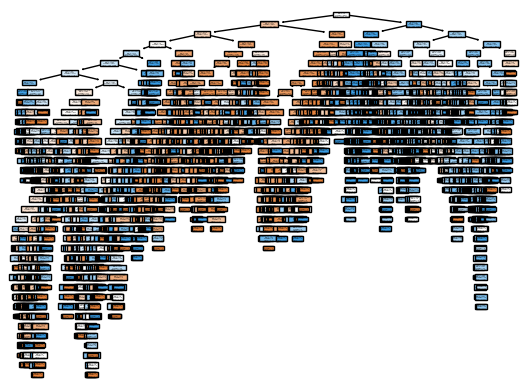

In [44]:
from sklearn.tree import DecisionTreeClassifier as DTC
tree = DTC().fit(X,Y)
from sklearn.tree import plot_tree

plot_tree(tree,filled=True, feature_names= X.columns);
plt.show()





Ahora se utilizará una técnica de validación cruzada para poder generar un árbol podado que es el que será el modelo final. 

Primero se crea una lista de posibles valores de alpha, luego se calcula el accuracy estimado para cada posible árbol con cada valor de alpha y se elige el que de un resultado más alto. 



In [45]:
kfc = KFold(n_splits= 8)

#Generar valores de alfa
ccp=  np.linspace(0.001,0.2,250)
cv_scores = []

for alpha in ccp:
    pruned_tree = DTC(ccp_alpha=alpha)
    cv_scores.append(np.mean(cross_val_score(pruned_tree,X,Y,cv=kfc,scoring='accuracy')))

alpha = ccp[np.argmax(cv_scores)]



El árbol de decisiones tiene una accuracy de 0.781. 

Si se presta atención al árbol de decisiones las variables que más se repiten y más reducen el gini índex son las relacionadas a la cantidad de dinero gastada en cada parte del crucero, el cryosleep y en que parte de la cubierta estaban los pasajeros. 


In [46]:
plt.figure(figsize = (150,100))
pruned_tree = DTC(ccp_alpha = alpha).fit(X,Y)
plot_tree(pruned_tree,filled=True,feature_names=X.columns);
plt.show()


print("Accuracy del árbol de decisiones por k-folds cross validation: ",np.mean(cross_val_score(pruned_tree,X,Y,cv=kfc,scoring='accuracy')))


Accuracy del árbol de decisiones por k-folds cross validation:  0.7818980933212027


Siguiendo la línea de los árboles de decisiones, a continuación se utilizará un modelo de adaptive boosting. Para esto se utilizará la función de AdaBoostClassifier de sklearn.ensemble de sklearn. 
En los parámetros de la función se utilizará un árbol de decisiones como estimador, y se utilizarán técnicas de validación cruzada para encontrar el learning rate que maximice el accuracy. La profundidad máxima de cada árbol será la profundidad del árbol que se utilizó anteriormente. 
Cómo este modelo es más lento, la validación cruzada para elegir el hiperparámetro va a ser con 2 folds para reducir el tiempo de computación. Sin embargo, para calcular el accuracy va a ser igual que para el resto de los modelos. 


In [47]:
from sklearn.ensemble import AdaBoostClassifier as ABC
kfcBoost = KFold(n_splits = 2)
llr = np.linspace(0.001,1,20)
cvboost_scores = []
for alpha in llr:
    #era para revisar el proceso en lo que compilaba print(alpha)
    learningRateChange = ABC(estimator = DTC(max_depth=10), n_estimators = 250, learning_rate = alpha)
    cvboost_scores.append(np.mean(cross_val_score(learningRateChange,X,Y,cv=kfcBoost,scoring='accuracy')))

alpha = llr[np.argmax(cvboost_scores)]
print("Mejor learning rate: ",alpha)



c:\Users\ethan\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\ethan\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\ethan\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\ethan\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\eth

Mejor learning rate:  0.26389473684210524


In [48]:
abc = ABC(estimator = DTC(max_depth=10), n_estimators = 250, learning_rate = alpha)

scores4 = cross_val_score(abc,X,Y,scoring='accuracy',cv = kfc)

abc.fit(X,Y)


c:\Users\ethan\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\ethan\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\ethan\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\ethan\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\eth

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=10),
                   learning_rate=0.26389473684210524, n_estimators=250)

El accuracy para el modelo de boosting es de 0.774. 

In [ ]:
print("Accuracy por K-folds cv para Boosting", np.average(scores4))


Accuracy por K-folds cv para Boosting 0.7769495850000254
[1. 0. 1. ... 1. 1. 0.]
  PassengerId  Transported
0     0013_01          1.0
1     0018_01          0.0
2     0019_01          1.0
3     0021_01          1.0
4     0023_01          1.0


El accuracy para el modelo de boosting es de 0.774, que no es el más bajo, pero tampoco el más alto. 
En todos los modelos se hicieron predicciones y se guardaron los datos en un .csv. Sin embargo, no se detalló como se hizo. Para todos los modelos el proceso fue utilizar la función predict para conseguir un vector con los valores predichos. 

Después se convirtió en un dataframe y se concatenó con los id's de pasajeros correspondientes. Finalmente, se convirtieron los 1's y 0's numéricos en booleanos que se exportaroón a un csv. 


In [ ]:
Yhat1 = abc.predict(test)
print(Yhat1)
Yhat1df= pd.DataFrame()
Yhat1df["Transported"]= pd.DataFrame(Yhat1)
Yhat1df = pd.concat([TestPId,Yhat1df],axis=1)

print(Yhat1df.head())

Yhat1df.Transported = Yhat1df.Transported>0.5

Yhat1df.to_csv("Boosting.csv",index=False)


Hasta el momento las accuracies de cada uno de los modelos han sido muy similares, pero la más alta de todas es la del árbol de decisiones. Ese fue el primer modelo que subí a la competencia y fue con el que tuve un puntaje más alto. 

Aquí se presenta un resumen de las accuracies de cada modelo: 

Logit sin selección de características: <br>
0.78799<br>
Logit con selección de características: <br>
0.78339<br>
LDA: <br>
0.76809<br>
Árbol de decisiones: <br>
0.781<br>
Boosting: <br>
0.78799<br>


Se considera que este desempeño es suficientemente bueno y hasta aquí se dejará el trabajo. 

